## Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Creating the sine wave dataset

In [2]:
x = np.linspace(0,50,501)
y = np.sin(x)
# plt.plot(x,y)

In [3]:
df = pd.DataFrame(data=y, index=x, columns = ['Sines'])
df.tail()

,Sines
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400
50.0,-0.262375


## Train test split the dataset

In [4]:
test_percent = 0.1
len(df)*test_percent

50.1

In [5]:
test_point = np.round(len(df)*test_percent)
test_point

50.0

In [6]:
test_index = int(len(df)-test_point)
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [7]:
print(train.shape, test.shape)

(451, 1) (50, 1)


## Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 30
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=batch_size)
val_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                length=length, batch_size=batch_size)

In [11]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

n_features = 1

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(length,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

In [12]:
model.fit(generator, validation_data=val_generator, epochs=20)

Epoch 1/20
421/421 [==============================] - 2s 3ms/step - loss: 0.0091 - val_loss: 4.3977e-06
Epoch 2/20
421/421 [==============================] - 1s 3ms/step - loss: 1.3503e-04 - val_loss: 2.2865e-04
Epoch 3/20
421/421 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 4.9176e-04
Epoch 4/20
421/421 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 8.6744e-05
Epoch 5/20
421/421 [==============================] - 1s 3ms/step - loss: 6.8208e-05 - val_loss: 1.0889e-06
Epoch 6/20
421/421 [==============================] - 1s 2ms/step - loss: 1.3737e-05 - val_loss: 7.1445e-06
Epoch 7/20
421/421 [==============================] - 1s 2ms/step - loss: 1.2638e-04 - val_loss: 2.5002e-04
Epoch 8/20
421/421 [==============================] - 1s 2ms/step - loss: 6.9384e-04 - val_loss: 9.4683e-05
Epoch 9/20
421/421 [==============================] - 1s 2ms/step - loss: 8.0938e-04 - val_loss: 1.7194e-05
Epoch 10/20
421/421 [===================

In [13]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))  

for i in range(len(test)):
    current_pred = model.predict(current_batch, verbose=0)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions_lstm'] = true_predictions


C:\Users\younu\AppData\Local\Temp\ipykernel_14928\517022708.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions_lstm'] = true_predictions


<AxesSubplot:>

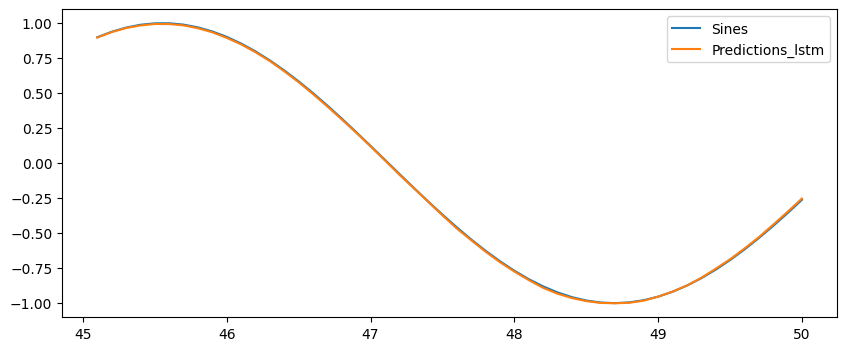

In [14]:
test.plot(figsize = (10,4))

## Train on full dataset

In [15]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [16]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=batch_size)

In [17]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(length,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mse')

In [18]:
model.fit(generator, epochs=10)

Epoch 1/10
471/471 [==============================] - 2s 2ms/step - loss: 0.0063
Epoch 2/10
471/471 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 3/10
471/471 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 4/10
471/471 [==============================] - 1s 2ms/step - loss: 1.0873e-04
Epoch 5/10
471/471 [==============================] - 1s 2ms/step - loss: 2.1933e-04
Epoch 6/10
471/471 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 7/10
471/471 [==============================] - 1s 2ms/step - loss: 1.7119e-05
Epoch 8/10
471/471 [==============================] - 1s 2ms/step - loss: 1.5727e-04
Epoch 9/10
471/471 [==============================] - 1s 2ms/step - loss: 3.6139e-04
Epoch 10/10
471/471 [==============================] - 1s 2ms/step - loss: 6.4171e-04


In [19]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))  

for i in range(100):
    current_pred = model.predict(current_batch, verbose=0)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [20]:
forecast = scaler.inverse_transform(forecast)

In [21]:
forecast_index = np.arange(50.1, 60.1, step=0.1)

In [22]:
len(forecast_index), len(forecast)

(100, 100)

In [23]:
100*.1

10.0

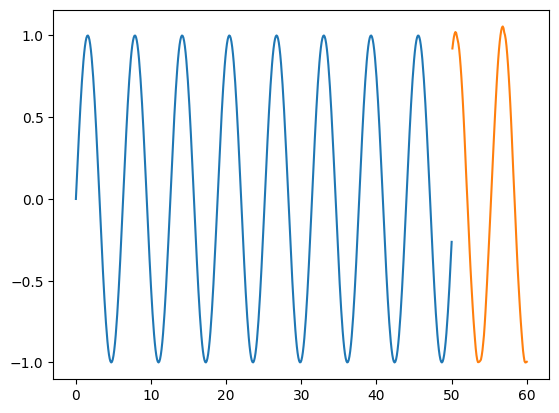

In [24]:
plt.plot(df.index, df['Sines'])
plt.plot(forecast_index, forecast)